First import the packages needed

In [5]:
import numpy as np
import pyccl as ccl
import pylab as plt
import pandas as pd

Define a cosmology object, for now we are using the same as in the examples

In [6]:
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

For reference, the paramteres are $h$ = Hubble's constant, $\Omega_c$ = Dark matter density parameter, $\Omega_b$ = Baryon density parameter, $\sigma_8$ = RMS matter fluctuation averaged over a sphere radius $8h^{-1}$Mpc, $n_s$ = scalar spectral index

### We now read in a sample of galaxies
We do this by reading in our redshift data from the survey with numpy's loadtxt method

In [7]:
dNdz_lens = np.loadtxt('dNdz_srcs_LSSTSRD_Y1.dat') #lensing data
dNdz_clust = np.loadtxt('dNdz_clust_LSSTSRD_Y1.dat') #clustering data
b = 1.5*np.ones(2000)

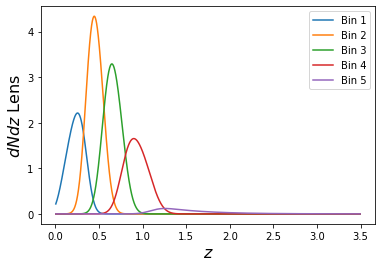

In [8]:
for i in range(5):
    plt.plot(dNdz_lens[:,0], dNdz_lens[:,i+1], label = f'Bin {i+1}') #column 0 is the redshift value 
    
plt.legend()
plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$dNdz$ Lens', fontsize = 16)
plt.show()

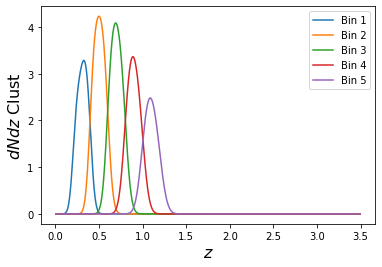

In [9]:
for i in range(5):
    plt.plot(dNdz_clust[:,0], dNdz_clust[:,i+1], label = f'Bin {i+1}')
    
plt.legend()
plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$dNdz$ Clust', fontsize = 16)
plt.show()

Above we have the number density distribution of galaxies by redshift

### We now create tracer objects
Not entirely sure what this does, CCL manages calculations through these tracer objects, ask about this further
We will create one for lensing and one for clustering effects

In [31]:
#Here we create an array that contains tracer objects for each redshift bin
#since there is no correlation between bins in clustering, we only do tracers for bin1-bin1, bin2-bin2, e.t.c
tracers_clust = []
for i in range(5):
    tracers_clust.append(ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(dNdz_clust[:,0],dNdz_clust[:,i+1]), bias=(dNdz_clust[:,0],b)))
    
print(tracers_clust)

[<pyccl.tracers.NumberCountsTracer object at 0x7f3b1f3cec18>, <pyccl.tracers.NumberCountsTracer object at 0x7f3b1f3ceba8>, <pyccl.tracers.NumberCountsTracer object at 0x7f3b1f3ce390>, <pyccl.tracers.NumberCountsTracer object at 0x7f3b1f3ce240>, <pyccl.tracers.NumberCountsTracer object at 0x7f3b1f3cecc0>]


In [27]:
#Let's try making the same tracer array for lensing, which does have correlation between bins

tracers_lens = []

for i in range(5):
    tracers_lens.append(ccl.WeakLensingTracer(cosmo, dndz=(dNdz_lens[:,0], dNdz_lens[:,i+1])))

### C$_\ell$ value calculation


First we load in the ell-values file

In [12]:
ell = np.loadtxt('ell-values')
print(ell)

[   23.5997     32.8594     45.75227    63.70386    88.69901   123.5014
   171.959     239.4297    333.3735    464.1775    646.3045    899.8917
  1252.978    1744.602    2429.122    3382.225    4709.291    6557.052
  9129.808   12712.02   ]


Now we can calculate the values of $C_\ell$ for each different source using the ccl method, we plot these values against $\ell$ to check that they look alright. Firstly we calculate the values for the clustering-clustering or shear-shear.

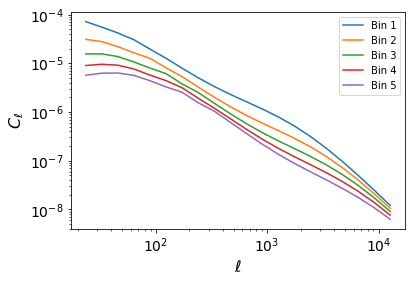

In [13]:
cls_clus = []

for i in range(len(tracers_clust)):
    cls_clus.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_clust[i], ell))
    
    plt.plot(ell, cls_clus[i], label = f'Bin {i+1}')

plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('$\ell$', fontsize = 16)
plt.ylabel('$C_\ell$', fontsize = 16)
plt.legend()
plt.show()

Now the same for lensing, using nested for loops due to the cross correlation between bins. We also include an if statement to exclude duplicate $C_\ell$'s, as for lensing $C_\ell (B_1,B_2) = C_\ell (B_2, B_1)$ e.t.c

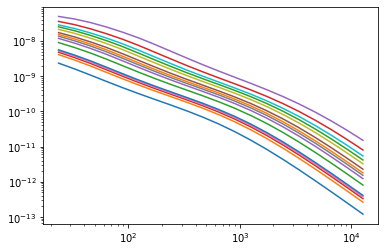

In [14]:
cls_lens = []

for i in range(len(tracers_lens)):
    for j in range(len(tracers_lens)):
        if i >= j:    #The if statement here excludes duplicate C_ells as for lensing C(bin1,bin2) = C(bin2, bin1)
            cls_lens.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_lens[j], ell))

#Now we plot as before, to see that this looks correct
for n in range(len(cls_lens)):
    plt.plot(ell, cls_lens[n])

    
plt.xscale('log')
plt.yscale('log')
plt.show()

Now we look at $C_\ell$ for the galaxy-galaxy lensing, using the array "gglensing" to tell which bin combinations are to be accepted and which are not to. This is because if the clustering source is closer than the lensing source, the value would be 0, with some additional noise.

In [15]:
#Now for the galaxy-galaxy lensing, which is a combination of the lensing and clustering tracers
gglensing = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

cls_gg = []

for i in range(len(tracers_lens)):
    for j in range(len(tracers_clust)):
        cls_gg.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_lens[j], ell))

cls_gg_clean = []

for n in range(len(gglensing)):
    if gglensing[n] == 1:
        cls_gg_clean.append(cls_gg[n])

print(len(cls_gg_clean))
#cls_gg_clean should be an array of cl values for galaxy-galaxy lensing bins that are NOT supposed to be 0

7


Again, plotting to make sure this looks right

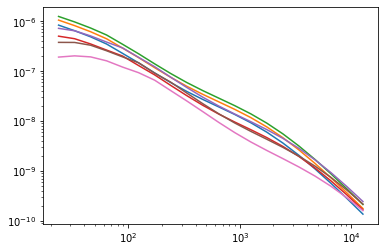

In [16]:
for n in range(len(cls_gg_clean)):
    plt.plot(ell, cls_gg_clean[n])
    
plt.yscale('log')
plt.xscale('log')
plt.show()

Because of using the base python function ".append", the structure of these arrays is a little bit off. Each index in the array is infact a list in itself, this can be cleaned up a bit for use in plotting by using the numpy method version of append, which automatically "flattens" the dimensins of the array unless specified otherwise. (np.reshape() could also be use here)

In [17]:
#Clean up the shape of the galaxy-galaxy cl value array
cls_gg_clean1 = np.append([], cls_gg_clean)
cls_gg_clean = cls_gg_clean1

print(len(cls_gg_clean)) #The length of this array should be 140- accoridng to the readme

140


In [18]:
#Get cls_lens into a more appropriate form
cls_lens1 = np.append([], cls_lens)
cls_lens = cls_lens1
print(len(cls_lens)) #Should be 300 according to the readme

300


In [19]:
#Try to get cls_clus in an appropriate form 
cls_clus1 = np.append([], cls_clus)
cls_clus = cls_clus1
print(len(cls_clus)) #Should be 100 according to the readme

100


Now we combine the clustering, galaxay-galaxy and lensing $C_\ell$ arrays into one combined array for use in plotting against array index. It is important to note that the arrays must be combined in this specific order or the plot will look off.

In [20]:
#Combining the clustering, galaxy-galaxy lensing, and lensing c_ell arrays into one combined array for plotting against index
cls_clus_gg = np.append(cls_clus, cls_gg_clean)
cls_combined = np.append(cls_clus_gg, cls_lens)

print(len(cls_combined)) #The length of this should be (100 + 140 + 300) = 540

540


We can now finally plot our combined $C_\ell$ array against array index.

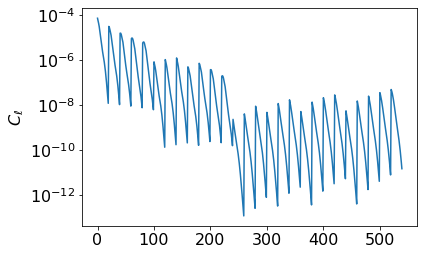

In [21]:
#Plotting the combined c_ell values against index. NOTE : if you just use "plt.plot(y)", y is automatically plotted against
#index number, so no need to making some array that represents the index as done before
plt.plot(cls_combined)

plt.yscale('log')
plt.ylabel('$C_\ell$', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

## Varying cosmological parameters
Now that we've got a data vector with a correct for and that looks correct, we will work on being able to easily calculate a data vector as a function of the cosmological parameters that define the ccl cosmo object

In [55]:
#Define a dictionary for the parameters, for now we'll just use the ones we're already aware of
#cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
param = {'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'sigma8': 0.83, 'n_s': 0.96, 'bias': b = 1.5*np.ones(2000)}

In [57]:
def data_vector(params):
    cosmo = ccl.Cosmology(Omega_c = params['Omega_c'],\
                          Omega_b = params['Omega_b'],\
                          h = params['h'],\
                          sigma8 = params['sigma8'],\
                          n_s = params['n_s'])
    
    #Load in lensing and clustering distributions and ell
    dNdz_lens = np.loadtxt('dNdz_srcs_LSSTSRD_Y1.dat') 
    dNdz_clust = np.loadtxt('dNdz_clust_LSSTSRD_Y1.dat')
    ell = np.loadtxt('ell-values')
    
    #Construct tracer objects
    tracers_clust = []
    tracers_lens = []
    
    for i in range(5):
        tracers_clust.append(ccl.NumberCountsTracer(cosmo,\
                                                    has_rsd=False,\
                                                    dndz=(dNdz_clust[:,0],\
                                                    dNdz_clust[:,i+1]),\
                                                    bias=(dNdz_clust[:,0], params['bias'])))
    
        tracers_lens.append(ccl.WeakLensingTracer(cosmo, dndz=(dNdz_lens[:,0], dNdz_lens[:,i+1])))
    
    #Now that the tracers are constructed, calculate C_l's for shear, gg-lensing and lensing
    cls_clus = []
    cls_gg = []
    cls_gg_clean = []
    gglensing = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    cls_lens = []
    

    for i in range(len(tracers_clust)):
        for j in range(len(tracers_clust)):
            cls_clus.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_clust[i], ell))
            
            cls_gg.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_lens[j], ell))
            
            if i >= j:
                cls_lens.append(ccl.angular_cl(cosmo,tracers_lens[i], tracers_lens[j], ell))
                
    #Clean up the data vectors shapes and combine them all
    cls_clus_gg = np.append(cls_clus, cls_gg_clean)
    cls_combined = np.append(cls_clus_gg, cls_lens)

Done
pyccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, n_s=0.96, sigma8=0.83, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


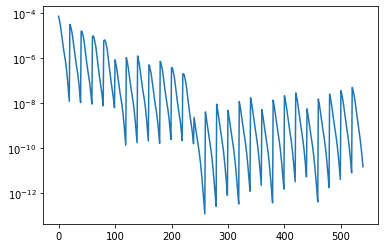

In [58]:
data_vector(parameters)
print(cosmo)
plt.plot(cls_combined)
plt.yscale('log')
plt.show()